<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformers_Processar_Dades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processant les dades**

---

És un exemple de fine-tuning amb TensorFlow per a models de Hugging Face.

In [ ]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = dict(tokenizer(sequences, padding=True, truncation=True, return_tensors="tf"))

# This is new
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
labels = tf.convert_to_tensor([1, 1])
model.train_on_batch(batch, labels)

# **Procés:**

---
1. Importar TensorFlow i NumPy

1. Importar el tokenitzador i el model BERT per a classificació de seqüències (versió TensorFlow)

1. Carregar el model preentrenat bert-base-uncased: versió de BERT que no distingeix majúscules i minúscules.

1. Carregar el tokenitzador i el model preentrenat per a classificació de textos.
1. S'apliquen dues frases per fer servir per entrenar.
1. Es tokenitzen les frases:

  *   padding=True: afegeix zeros perquè totes les frases tinguin la mateixa longitud
  *   truncation=True: talla si són massa llargues
  *   return_tensors="tf": retorna tensors per TensorFlow

  *   El dict() converteix l’objecte en un diccionari apte per passar al model.

1. Aquest model no estava compilat, així que s’indica:

  *  Optimitzador: adam, molt comú i eficient

  *  Pèrdua: sparse_categorical_crossentropy, que és adequada quan tens classes etiquetades com a enters (no one-hot)
1. Etiquetes: Aquestes són les etiquetes reals (classes) per a les frases.

  *  Tant la primera com la segona frase tenen com a classe el valor 1.

  *  Per exemple: 0 = negatiu, 1 = positiu

1. Aquí es fa un pas d'entrenament (1 batch) amb les dues frases.Aquesta ordre:

  *  Passa els tokens com a entrada

  *  Passa les etiquetes com a sortida esperada

  *  Calcula la pèrdua i fa una actualització dels pesos del model


Aquest valor és la pèrdua (loss) després d’entrenar un batch. És un valor numèric que indica com s’ha ajustat el model a les etiquetes.

En aquest cas, 0.34 és raonable, tot i que l’exemple és massa petit per extreure conclusions.

# **Carregant un conjunt de dades des del "HUB"**

---
El Hub no només conté models; també té diversos conjunts de dades en molts idiomes diferents


In [ ]:
!pip install datasets

from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

In [ ]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[5]

In [ ]:
raw_train_dataset.features

In [7]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

In [8]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

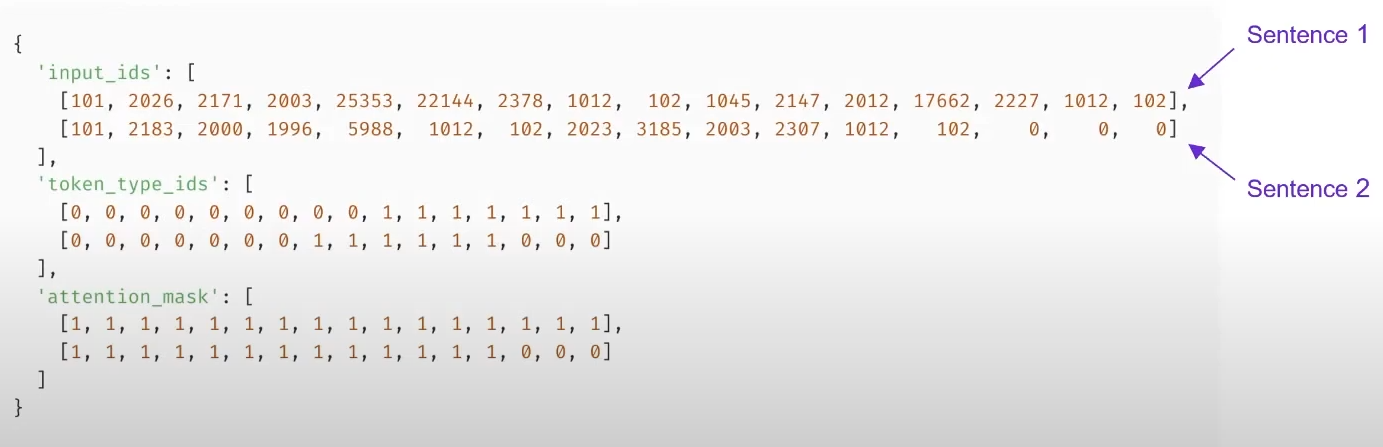

In [ ]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

Per mantenir les dades com a conjunt de dades, utilitzarem el mètode Dataset.map(). Això també ens permet una certa flexibilitat addicional, si necessitem més preprocessament que la simple tokenització. El mètode map() funciona aplicant una funció a cada element del conjunt de dades, així que anem a definir una funció que simbolitzi les nostres entrades:

In [10]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

# **Avantatges d’aquest enfocament (.map) respecte a tokenitzar "a mà":**

---
Avantatge:

1. Eficaç i ràpid	Processa tot el dataset de manera vectoritzada i eficient
1. No cal un bucle	No has de fer for ni gestionar tú mateix els input_ids, attention_mask, etc.
1. S’integra amb datasets	El resultat és un nou dataset Hugging Face, amb les columnes tokenitzades afegides
1. Conserva etiquetes	Les etiquetes (label, idx) es mantenen automàticament si no les sobrescrius
1. És escalable	Ideal per datasets grans (GLUE, SQuAD, etc.), ja que pot fer servir múltiples fils o multiprocessing






# **Dinàmic Padding**

---

El dynamic padding és quan el padding s’adapta automàticament a la seqüència més llarga del batch, en lloc de fixar una longitud màxima per a tot el dataset.

1. Més eficient	Menys tokens inútils → més ràpid
1. Millor ús de GPU/CPU	Menys espai en memòria ocupat per padding
1. Flexibilitat

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

1. Agafar 8 mostres de text ja tokenitzades.

1. Eliminar la informació que no cal per entrenar (idx, sentence1, sentence2).

1. Aplicar padding dinàmic a aquest petit lot amb DataCollatorWithPadding.

1. Observar les formes (shape) dels tensors resultants.

In [ ]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)